In [37]:
# Impor library yang diperlukan
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.fft import fft
from scipy.signal import butter, lfilter

In [38]:
# Unggah file dataset
print("Silakan upload file dataset")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
data = loadmat(file_name)

Silakan upload file dataset


Saving data_set_IVa_av.mat to data_set_IVa_av (3).mat


In [39]:
# Ekstrak informasi dari dataset
print("Kunci dalam dataset:", data.keys())
cnt = data['cnt']                      # Sinyal EEG
mrk_pos = data['mrk'][0, 0]['pos'][0]  # Posisi marker
mrk_y = data['mrk'][0, 0]['y'][0]      # Label marker
clab = data['nfo']['clab'][0, 0][0]    # Label kanal
fs = data['nfo']['fs'][0, 0][0, 0]     # Frekuensi sampel

print("Dimensi cnt:", cnt.shape)
print("Frekuensi sampel (Hz):", fs)
print("Label kanal:", [clab[i][0] for i in range(len(clab))])

Kunci dalam dataset: dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'nfo', 'cnt'])
Dimensi cnt: (283042, 118)
Frekuensi sampel (Hz): 100
Label kanal: ['Fp1', 'AFp1', 'Fpz', 'AFp2', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'FAF5', 'FAF1', 'FAF2', 'FAF6', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FFC7', 'FFC5', 'FFC3', 'FFC1', 'FFC2', 'FFC4', 'FFC6', 'FFC8', 'FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'TP9', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'PCP7', 'PCP5', 'PCP3', 'PCP1', 'PCP2', 'PCP4', 'PCP6', 'PCP8', 'P9', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'P10', 'PPO7', 'PPO5', 'PPO1', 'PPO2', 'PPO6', 'PPO8', 'PO7', 'PO3', 'PO1', 'POz', 'PO2', 'PO4', 'PO8', 'OPO1', 'OPO2', 'O1', 'Oz', 'O2', 'OI1', 'OI2', 'I1',

In [40]:
# Cari indeks kanal
channel_index = None
for i, label in enumerate(clab):
    if label[0] == 'C3':
        print(f"Indeks C3: {i}, Label: {label[0]}")
        channel_index = i
        break
if channel_index is None:
    print("C3 tidak ditemukan, gunakan indeks default 51")
    channel_index = 51
print(f"Label kanal {channel_index}: {clab[channel_index][0]}")

Indeks C3: 51, Label: C3
Label kanal 51: C3


In [41]:
# Sinkronkan dengan marker untuk right hand imagery
right_hand_indices = np.where(mrk_y == 1)[0]
if len(right_hand_indices) > 0:
    start_sample_imagery = mrk_pos[right_hand_indices[0]] + int(1.0 * fs)  # 1 detik setelah isyarat
    signal_imagery = cnt[start_sample_imagery:start_sample_imagery + 200, channel_index] * 0.1  # 2 detik
    print("Segmen right hand imagery berhasil diekstraksi")
else:
    print("Tidak ada trial right hand, gunakan segmen awal")
    signal_imagery = cnt[:200, channel_index] * 0.1

Segmen right hand imagery berhasil diekstraksi


In [42]:
# Ambil segmen rest (2 detik sebelum isyarat)
if len(right_hand_indices) > 0:
    start_sample_rest = mrk_pos[right_hand_indices[0]] - int(2.0 * fs)
    signal_rest = cnt[start_sample_rest:start_sample_rest + 200, channel_index] * 0.1
    print("Segmen rest berhasil diekstraksi")
else:
    print("Tidak ada trial right hand untuk rest, gunakan segmen awal")
    signal_rest = cnt[200:400, channel_index] * 0.1

Segmen rest berhasil diekstraksi


In [43]:
# Fungsi filter bandpass
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [44]:
# Terapkan filter bandpass 8-30 Hz
lowcut = 8.0
highcut = 30.0
filtered_imagery = bandpass_filter(signal_imagery, lowcut, highcut, fs)
filtered_rest = bandpass_filter(signal_rest, lowcut, highcut, fs)
print("Filter bandpass 8-30 Hz diterapkan")

Filter bandpass 8-30 Hz diterapkan


In [45]:
# Hitung FFT untuk analisis frekuensi
N = len(signal_imagery)
yf_imagery = fft(filtered_imagery)
yf_rest = fft(filtered_rest)
xf = np.linspace(0.0, fs / 2.0, N // 2)

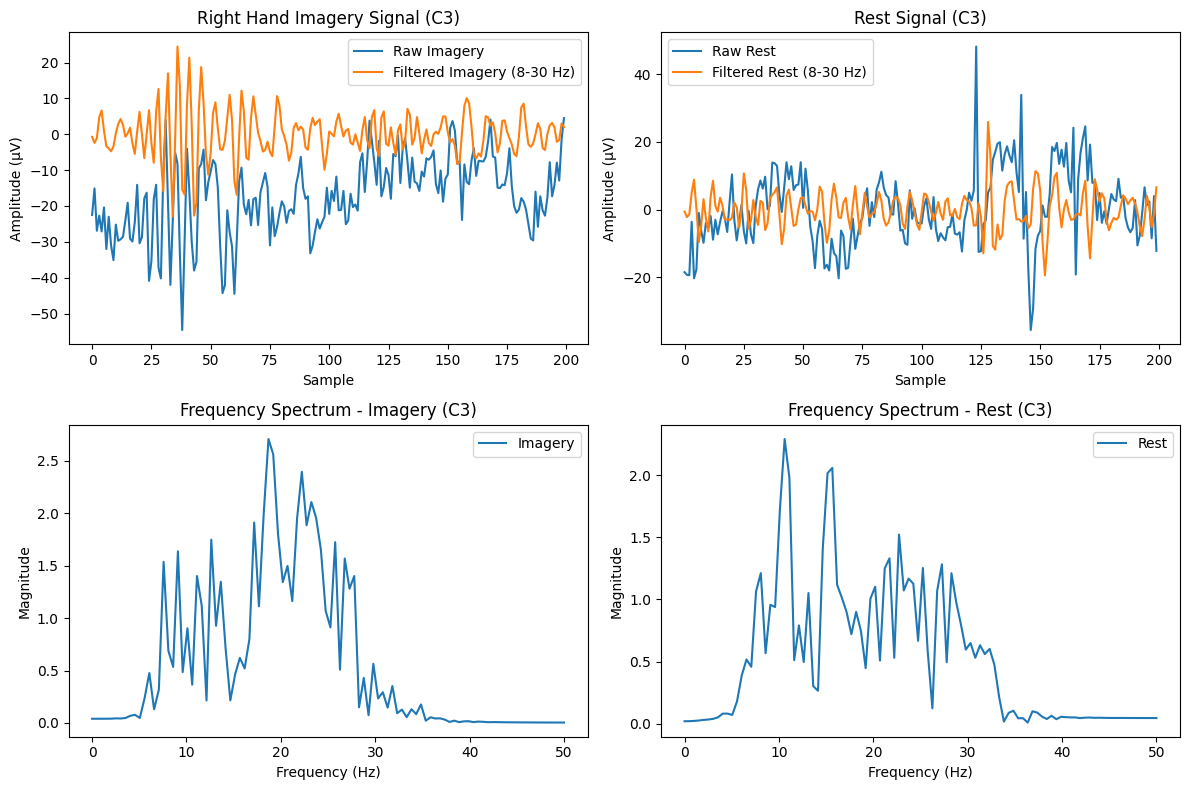

In [46]:
# Visualisasi
plt.figure(figsize=(12, 8))

# Plot sinyal waktu - Imagery
plt.subplot(2, 2, 1)
plt.plot(signal_imagery, label='Raw Imagery')
plt.plot(filtered_imagery, label='Filtered Imagery (8-30 Hz)')
plt.title("Right Hand Imagery Signal (C3)")
plt.xlabel("Sample")
plt.ylabel("Amplitude (μV)")
plt.legend()

# Plot sinyal waktu - Rest
plt.subplot(2, 2, 2)
plt.plot(signal_rest, label='Raw Rest')
plt.plot(filtered_rest, label='Filtered Rest (8-30 Hz)')
plt.title("Rest Signal (C3)")
plt.xlabel("Sample")
plt.ylabel("Amplitude (μV)")
plt.legend()

# Plot spektrum frekuensi - Imagery
plt.subplot(2, 2, 3)
plt.plot(xf, 2.0 / N * np.abs(yf_imagery[:N // 2]), label='Imagery')
plt.title("Frequency Spectrum - Imagery (C3)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()

# Plot spektrum frekuensi - Rest
plt.subplot(2, 2, 4)
plt.plot(xf, 2.0 / N * np.abs(yf_rest[:N // 2]), label='Rest')
plt.title("Frequency Spectrum - Rest (C3)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()

plt.tight_layout()
plt.show()